##### Copyright 2018 The TensorFlow Authors.
##### 텐서플로우 예제 참고

# attention 함수를 이용한 이미지 캡셔닝

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

# 맷플롯립
import matplotlib.pyplot as plt

# 사이킷런(데이터 분할, 셔플용)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import pprint
import cv2
print("텐서플로우 {} 버전이 실행중입니다.".format(tf.__version__))

텐서플로우 2.1.0 버전이 실행중입니다.


In [ ]:
# # Download caption annotation files
# annotation_folder = '/annotations/'
# if not os.path.exists(os.path.abspath('.') + annotation_folder):
#   annotation_zip = tf.keras.utils.get_file('captions.zip',
#                                           cache_subdir=os.path.abspath('.'),
#                                           origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
#                                           extract = True)
#   annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
#   os.remove(annotation_zip)

# # Download image files
# image_folder = '/train2014/'
# if not os.path.exists(os.path.abspath('.') + image_folder):
#   image_zip = tf.keras.utils.get_file('train2014.zip',
#                                       cache_subdir=os.path.abspath('.'),
#                                       origin = 'http://images.cocodataset.org/zips/train2014.zip',
#                                       extract = True)
#   PATH = os.path.dirname(image_zip) + image_folder
#   os.remove(image_zip)
# else:
#   PATH = os.path.abspath('.') + image_folder

## 1. 데이터 전처리
* 데이터 수 제한하기(3000개만 추출)
* 속도를 빠르게 하기 위해서 30000개만으로 학습한다. 더 많은 그림을 넣으면 모델 품질이 개선된다.

In [4]:
# json 파일 읽기
annotation_file = './annotations/captions_train2014.json'
PATH = './train2014/'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
# json 파일 뽑아보기
print('---------------------annotations----------------------')
pprint.pprint(annotations['annotations'][:3])

# 캡션, 이미지 벡터 저장
all_captions = []
all_img_path = []

for annot in annotations['annotations']:
    # <start>와 <end>를 처음과 끝에 넣어 구분해준다.
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
    # 이미지 패스 저장
    all_img_path.append(full_coco_image_path)
    # 이미지 캡션 저장
    all_captions.append(caption)

# 캡션과 이미지 섞기
train_captions, img_path = shuffle(all_captions,all_img_path,random_state=1)
# 섞은 이미지에서 30000개 추출
print(len(train_captions))
num_examples = 300000
train_captions = train_captions[:num_examples]
img_path = img_path[:num_examples]


---------------------annotations----------------------
[{'caption': 'A very clean and well decorated empty bathroom',
  'id': 48,
  'image_id': 318556},
 {'caption': 'A panoramic view of a kitchen and all of its appliances.',
  'id': 67,
  'image_id': 116100},
 {'caption': 'A blue and white bathroom with butterfly themed wall tiles.',
  'id': 126,
  'image_id': 318556}]
414113


---------------------all_captions----------------------

['<start> A very clean and well decorated empty bathroom <end>',
 '<start> A panoramic view of a kitchen and all of its appliances. <end>',
 '<start> A blue and white bathroom with butterfly themed wall tiles. <end>']
---------------------all_img_name_vector----------------------



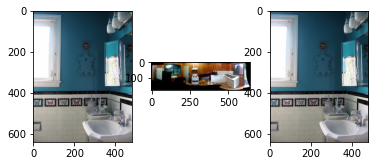

In [31]:
# all_captions 뽑아보기
print('---------------------all_captions----------------------')
print('')
pprint.pprint(all_captions[:3])
# all_img_name_vector 뽑아보기
print('---------------------all_img_name_vector----------------------')
print('')
i = 1
for path in all_img_path[:3]:
    plt.subplot(1,3,i)
    plt.imshow(plt.imread(path))
    i += 1


---------------------train_captions----------------------

['<start> A skateboarder performing a trick on a skateboard ramp. <end>',
 '<start> a person soaring through the air on skis <end>',
 '<start> a wood door with some boards laid against it <end>']
---------------------img_path----------------------

['./train2014/COCO_train2014_000000324909.jpg',
 './train2014/COCO_train2014_000000511972.jpg',
 './train2014/COCO_train2014_000000508809.jpg']


(300000, 414113)

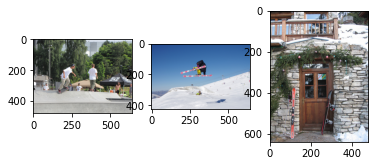

In [30]:

# train_captions 뽑아보기
print('---------------------train_captions----------------------')
print('')
pprint.pprint(train_captions[:3])
# img_name_vector 뽑아보기
print('---------------------img_path----------------------')
print('')
pprint.pprint(img_path[:3])
i = 1
for path in img_path[:3]:
    plt.subplot(1,3,i)
    plt.imshow(plt.imread(path))
    i += 1
len(train_captions), len(all_captions)

## InceptionV3를 이용한 이미지 전처리
### 다음으로 InceptionV3(미리 학습된 Imagenet)을 이미지를 분류하기 위해서 사용함. 마지막 컨볼루션 레이어의 피쳐를 추출하게 됨
### 처음으로 이미지를 로드해서:
* 이미지를 299 * 299로 리사이징
* InceptionV3를 훈련시키기 위해 이미지 형식에 맞는 -1 ~ 1 범위 픽셀로 노멀라이징한다.

In [32]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## InceptionV3 초기화 및 사전 훈련된 Imagenet 가중치 로드

이제 출력 계층이 InceptionV3 아키텍처의 마지막 convolutional 계층인 결과물 크기 8x8x2048인 tf.keras 모델을 생성. 
이 예에 마지막 convolutional 레이어는  attention 기법을 사용함. 

* 각 이미지를 네트워크를 통해 전달하고 결과 벡터를 딕셔너리 객체(image_name --> feature_vector)에 저장한다.
* 모든 이미지가 네트워크를 통해 전달되면 객체를 선택해 디스크에 저장한다.

In [33]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
# 마지막 레이어 갈아끼워주는 과정
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

][0]             
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, None, None, 1 147456      average_pooling2d_15[0][0]       
__________________________________________________________________________________________________
batch_normalization_154 (BatchN (None, None, None, 1 576         conv2d_154[0][0]                 
__________________________________________________________________________________________________
batch_normalization_157 (BatchN (None, None, None, 1 576         conv2d_157[0][0]                 
__________________________________________________________________________________________________
batch_normalization_162 (BatchN (None, None, None, 1 576         conv2d_162[0][0]                 
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, None, None, 1 576         conv2d_163[0][0]          

## InceptionV3을 이용해서 피쳐를 추출하는 캐싱 수행하기

InceptionV3로 각 이미지를 전처리하고 출력을 디스크에 캐시할 것이다. 
출력을 RAM으로 캐싱하는 것은 더 빠르지만 메모리 집약적이어서 이미지당 8 \* 8 \* 2048 float가 필요하고, 메모리 제한 초과 가능성이 높다.
좀 더 정교한 캐싱 전략(예: 랜덤 액세스 디스크 I/O를 줄이기 위해 이미지를 쉐딩하는 것)으로 성능을 향상시킬 수 있지만, 이는 더 많은 코드를 필요로 할 것이다.
Colab 기준 약 10분이 소요된다.

In [9]:
from tqdm import tqdm
# 이미지 유니크화
encode_train = sorted(set(img_path))

# 각자의 컴퓨터 사항에 맞게 batch_size를 작성해 줄 것
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
# 본 노트북에서 약 06:04분의 소요시간이 걸렸음

t [02:51,  5.24it/s]
793it [02:51,  5.34it/s]
794it [02:51,  5.45it/s]
795it [02:51,  5.12it/s]
796it [02:52,  4.03it/s]
797it [02:52,  3.86it/s]
798it [02:52,  3.98it/s]
799it [02:53,  3.97it/s]
800it [02:53,  4.06it/s]
801it [02:53,  4.23it/s]
802it [02:53,  4.13it/s]
803it [02:53,  4.13it/s]
804it [02:54,  4.28it/s]
805it [02:54,  4.36it/s]
806it [02:54,  4.31it/s]
807it [02:54,  4.24it/s]
808it [02:55,  4.31it/s]
809it [02:55,  4.18it/s]
810it [02:55,  4.15it/s]
811it [02:55,  4.23it/s]
812it [02:56,  4.33it/s]
813it [02:56,  4.20it/s]
814it [02:56,  3.74it/s]
815it [02:56,  3.66it/s]
816it [02:57,  3.58it/s]
817it [02:57,  3.66it/s]
818it [02:57,  2.88it/s]
819it [02:58,  2.88it/s]
820it [02:58,  3.19it/s]
821it [02:58,  3.49it/s]
822it [02:59,  3.71it/s]
823it [02:59,  3.90it/s]
824it [02:59,  4.09it/s]
825it [02:59,  4.11it/s]
826it [02:59,  4.08it/s]
827it [03:00,  4.11it/s]
828it [03:00,  4.25it/s]
829it [03:00,  4.37it/s]
830it [03:00,  4.37it/s]
831it [03:01,  4.29it/s]
832i

InvalidArgumentError: Invalid JPEG data or crop window, data size 32768
	 [[{{node DecodeJpeg}}]]

## 캡션의 사전 처리 및 토큰화

* 먼저 캡션을 토큰화한다(예: 공백으로 분할). 토큰화하여 유니크 데이터셋, 중복되지 않는 데이터셋을 얻는다.(예: "서핑", "축구" 등)
* 다음으로, 단어 크기를 상위 5,000 단어로 제한한다.(메모리 저장시 문제 예방),  그리고 데이터셋에 없을 경우 "UNK"(알 수 없음)으로 대체한다.
* 그런 다음 word2index(단어 -> 색인) 및 index2word (색인 -> 단어) 매핑을 만든다.
* 마지막으로 모든 시퀀스를 가장 긴 길이로 패딩한다.

In [34]:
# 데이터셋 최고 길이
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [35]:
# 5000개의 단어만 선택
top_k = 50000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# 토큰 벡터 만들기
train_seqs = tokenizer.texts_to_sequences(train_captions)
# 각각의 최고 길이에 맞게 길이를 맞추어 준다. 최고길이 값을 파라미터에 정해주지 않으면 자동으로 계산한다.
# 다음 예제에서는 49가 max값이므로 ex)[1,2,3] -> [1,2,3,0,0,0,0,0,0,0,0,0,...0](49)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# attention weights에 쓰일 최고 길이 계산
# 49개가 최고값이고 따라서 cap_vector 각각의 길이는 49개가 된다
max_length = calc_max_length(train_seqs)

In [9]:
print(len(train_seqs[0]))
print(len(cap_vector[0]))
print(max_length)

11
51
51


## 데이터셋 train,test셋으로 분리

In [36]:
# 데이터셋 8:2로 분리
img_path_train, img_path_val, cap_train, cap_val = train_test_split(img_path, cap_vector,test_size=0.2,random_state=0)
len(img_path_train), len(cap_train), len(img_path_val), len(cap_val)

(240000, 240000, 60000, 60000)

## tf.data 데이터셋 만들기
* 모델에 쓸 트레이닝 데이터셋 만들기

In [37]:
# 구성용 파라미터 모델 체우기
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
# 스텝은 총 길이 // 배치사이즈 
num_steps = len(img_path_train) // BATCH_SIZE

# InceptionV3에서 추출할 벡터는 (64,2048)
features_shape = 2048
attention_features_shape = 64

In [38]:
# 넘파이 파일 로딩함수
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [39]:
dataset = tf.data.Dataset.from_tensor_slices((img_path_train, cap_train))

# map 함수를 이용하여 numpy 파일을 평행하게 묶는다.
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
print(dataset)
# 데이터셋 섞기
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# 속도 개선을 위하여 프리패칭 진행
# (GPU의 계산 속도보다 데이터 로딩 속도가 느리기 때문에 미리 유추해서 다음 순서에 가져다 놓는 방식으로 진행하게 된다.)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

<ParallelMapDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>


## Model
아래의 decoder는 Neural Machine Translation with Attention의 예와 동일하다.

모델 아키텍처는 유명한 논문 show,Attend and Tell에서 제안한 방법이 쓰였다.

* 이 예제에서는 InceptionV3의 하부 conolutional layer에서 형상을 나타내는 벡터를 추출한다(8, 8, 2048).
* (64, 2048)로 축소시킨다.
* CNN dense를 통과한다.
* RNN(정확히는 GRU 모델을 사용)은 다음 단어를 예측하기 위해 이미지 다음에 쓰인다.

In [40]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # 마지막 axis = 1은 self.v에 점수를 제공해 주기 위함
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [41]:
class CNN_Encoder(tf.keras.Model):

    # pickle을 이용해 피쳐를 추출 후 이 인코더로 완전연결층(Dense)으로 전달한다 .
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        # Dense
        x = self.fc(x)
        # shape after fc == (batch_size, 64, embedding_dim)
        x = tf.nn.relu(x)
        return x

In [42]:
# 예제 BATCH_SIZE = 64, embedding_dim = 256, units = 512

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    # 임베딩 embedding_dim = 256차원으로 임베딩 시킨다.
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # 순환신경망에 GRU를 배치. 현재 RNN과 LSTM을 비롯한 순환신경망이며 성능으로 각광받고 있음
    self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    # 어텐션 계층.  
    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # 어텐션 함수의 결과를 weight와 벡터로 각각 저장
    context_vector, attention_weights = self.attention(features, hidden)
    # 임베딩 레이어를 통과한 후의 x shape -> (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # embedding과 hidden_size를 결합한 후의 x shape -> (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # 결합된 벡터를 GRU로 전달
    output, state = self.gru(x)
    # Dense1
    # x shape -> (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    # x shape -> (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    # Dense2
    # output shape -> (batch_size * max_length, vocab)
    x = self.fc2(x)
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [43]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [44]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

## Checkpoint

In [45]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [46]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # 마지막 최신의 checkpoint의 checkpoint_path로 다시 저장
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* 각 ".npy" 파일에 저장된 형상을 추출한 후 인코더를 통해 전달한다.
* 인코더 출력 은닉 상태(0으로 초기화)와 디코더 입력(시작 토큰)이 디코더로 전달된다.
* 디코더는 예측값과 디코더 숨겨진 상태를 반환한다.
* Decoder 은닉상태는 모델에 다시 전달되며, 예측값을 사용하여 손실을 계산한다.
* 해독기에 대한 다음 입력을 결정하기 위해 Teacher forcing을 사용한다.
* Teacher forcing은 해독기에 대한 다음 입력으로 대상어가 전달되는 기술이다.
* 마지막 단계는 gradients를 계산하여 optimizer 및 backpropagate에 적용하는 것이다.

In [47]:
# 별도 셀에 이것을 추가하는 이유는 훈련중 셀을 실행하면 loss_plot 배열이 리셋되기 때문이다.
loss_plot = []

In [48]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  # decoder.reset_state는 위에서 정의했음. 같은 shape로 0으로 만들어주는 함수. 
  # batch_size에 타겟의 shape를 넣으면 같은형상의 0 행렬로 변환
  # 매 hidden state마다 실행하는데 캡션은 이미지간에 관련이 없기 때문이다.
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      # 아까 정의한 CNN encoder를 실행하는 부분
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          # 아까 RNN decoder에서 정의한 디코더를 실행하는 부분
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [51]:
EPOCHS = 20
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        # 훈련부분. train_step의 batch_loss와 t_loss 저장
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    if epoch % 5 == 0:
      ckpt_manager.save()
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

UnknownError: FileNotFoundError: [Errno 2] No such file or directory: './train2014/COCO_train2014_000000303041.jpg.npy'
Traceback (most recent call last):

  File "C:\Users\multicampus\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow_core\python\ops\script_ops.py", line 236, in __call__
    ret = func(*args)

  File "<ipython-input-38-34101eb24bbb>", line 3, in map_func
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')

  File "C:\Users\multicampus\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\npyio.py", line 428, in load
    fid = open(os_fspath(file), "rb")

FileNotFoundError: [Errno 2] No such file or directory: './train2014/COCO_train2014_000000303041.jpg.npy'


	 [[{{node PyFunc}}]]

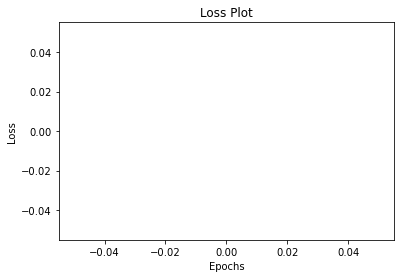

In [24]:
# 모델 훈련 완료 후 plot 차트 
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption

* evalutae은 training의 루프와 거의 유사하지만, 여기에는 train force 기능을 사용하지 않는다. 각 단계에서 디코더에 대한 입력은 숨겨진 상태 및 인코더 출력과 함께 이전의 예측이다.
* 모델이 <end> 토큰에 가게되면 멈춘다.
* 각 단계별로 attention weight를 저장한다.

In [26]:
def evaluate(image):
    # 0 행렬로 초기화
    attention_plot = np.zeros((max_length, attention_features_shape))
    # decode.reset_state로 초기값으로 지정해줌
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    # CNN encoder로 마무리
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(max_length):
        # decoder로 캡션 생성하는 부분
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [27]:
# plot으로 뽑아서 시각화시키는 부분
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [28]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
# 이미지 평가부
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


NameError: name 'img_name_val' is not defined

## 이미지 캡셔닝 
방금 훈련한 모델에 적용한다.

In [29]:
# 이미지 url은 practice에 해당 이미지 파일을 저장 후 다음 경로에 넣고 실행하면 된다.
# ex) image_url = './practice/02.jpg'
image_url = './practice/02.jpg'
image_extension = image_url[-4:]
result, attention_plot = evaluate(image_url)
print(' '.join(result))
Image.open(image_url)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc1 in position 63: invalid start byte